# PyIceberg 🐍 Tabular Custom Snowflake Mirroing Guide
Hey, welcome! 

This guide shows how you can mirror tables from your Tabular catalog into Snowflake.

Tabular offers warehouse-wide automated mirroring to Snowflake that works in most cases, but there are a few situations where you may want something different:
- you may want to mirror just a few of your tables
- you may want to mirror an iceberg table to multiple Snowflake locations
- maybe you want to mirror before an ETL job kicks off (like dbt) rather than mirroring constantly with every change to your iceberg table
- probably some other reasons, who knows 🤷

### Guide Overview:
Buckle up, because this one has a few steps. Broadly, this is what we'll do:
1. Setup Tabular (assuming you already have a warehouse there)
- Get a service credential
- take note of your warehouse's location in s3 as you'll need that
2. Setup Snowflake:
- create some assets / service account in snowflake
- take note of some generated values that snowflake will give you
3. Setup AWS:
- Snowflake needs a role and some s3 read access after step 2
4. Get down to business!
- we'll use pyiceberg to mirror our tables to snowflake using everything we set up above
- luckily steps 1-3 are all one time initial set up, so from here on out we're good to go.

### Python Dependencies:
- clone this repo (just do it, it takes 2 seconds)
- cd into this folder
- install packages: `poetry install`

See, that wasn't so bad.


## 1. Tabular Setup:
- head over to app.tabular.io and log in (or signup if you don't already have an account)
- go to connections > security > service account and hit the big + button to create a new service account credential
- assign your service account credential to a role that has the correct access for what you want to do (if you don't know, `EVERYONE` is a pretty safe default)
  - We will need full read on your cdc changelog tables
  - We will also need write to the location you want your mirror tables to end up in
- copy that credential!
- come back here and create a `.env` file in this directory (`guides/pyiceberg_cdc_automation/.env`). Edit it to look like below and make sure to SAVE IT.
```
TABULAR_CREDENTIAL=t-asdf:1234
```
⬆️ replace `t-asdf:1234` with the tabular credential you just created. 

Good job! Now we're ready to get down to business 💪

# Snowflake Setup
Now its time to set up some access in Snowflake. Here's what you'll need:
- a user account for this code to use to issue iceberg table create commands
- that user account needs to have a default role assigned with access to:
  - create tables in your desired database/schema 
  - use a data warehouse
  - use the catalog and external volume you'll create below

That's it! Probably!

Here's a sample Snowflake script to get this cooking. The emojis point out places where you need to add values yourself:
```sql
// -----------------------------------------------
// create security admin assets
// -----------------------------------------------
use role securityadmin;
create role pyiceberg_mirroring_service_role;
grant role pyiceberg_mirroring_service_role to role sysadmin; 

// you can create these if they do not exist. This guide is just a starting point
grant usage on database my_target_database🪐 to role pyiceberg_mirroring_service_role;
grant ownership on schema my_target_database🪐.my_mirroring_schema🧊 to role pyiceberg_mirroring_service_role copy grants;
grant usage on warehouse some_cool_warehouse 🪐 to role pyiceberg_mirroring_service_role; // an xs is plenty here. Just doing some metadata ops 💪

create user pyiceberg_mirroring_service_user 
  password = '😎',
  default_role = pyiceberg_mirroring_service_role,
  default_warehouse = some_cool_warehouse 🪐; 
  
grant role pyiceberg_mirroring_service_role to user pyiceberg_mirroring_service_user;
// -----------------------------------------------


// -----------------------------------------------
// create account admin assets 
// -----------------------------------------------
use role accountadmin;
create external volume tabular_my_cool_warehouse_volume // I like to name these same as my warehouse, so tabular_enterprise_data_warehouse_volume for example 
  allow_writes=false
  storage_locations = ((
      name = 🌞'tabular_my_cool_warehouse_volume'
      storage_provider = 'S3'
      storage_aws_role_arn = 🌞'arn:aws:iam::account_id:role/snowflake-tabular-my-cool-warehouse-volume' // call this what you like. We will create the role in your aws account after this
      storage_base_url = 🌞's3://my-s3-bucket-where-tabular-puts-my-warehouse/my-warehouse-uuid-probably/' // this is the s3 location of your tabular warehouse.
  ));

create catalog integration tabular_my_cool_warehouse_catalog
  catalog_source = object_store
  table_format = iceberg
  enabled = true
  comment = 'Tabular.io Catalog Integration';
  
// let the service role use these nifty new iceberg objects
grant usage on integration tabular_my_cool_warehouse_catalog to role pyiceberg_mirroring_service_role;
grant usage on volume tabular_my_cool_warehouse_volume to role pyiceberg_mirroring_service_role;
// -----------------------------------------------


// -----------------------------------------------
// Get details from newly-created integration 
// objects. 
// -----------------------------------------------
use role pyiceberg_mirroring_service_role;
use warehouse some_cool_warehouse 🪐;
describe external volume tabular_my_cool_warehouse_volume;


// this query will give you 2 values you will need to create the snowflake access role in AWS
select 
  parse_json("property_value"::string):"STORAGE_AWS_ROLE_ARN"::string as storage_aws_iam_role_arn,
  parse_json("property_value"::string):"STORAGE_AWS_IAM_USER_ARN"::string as storage_aws_iam_user_arn,
  parse_json("property_value"::string):"STORAGE_AWS_EXTERNAL_ID"::string as storage_aws_external_id
  
from table(result_scan(last_query_id()))

where "parent_property"='STORAGE_LOCATIONS' and "property"='STORAGE_LOCATION_1';

```

🚧 Quick check!
- make sure to grab those three important fields from Snowflake -- or just keep them handy for the AWS step
- I attached a screenshot of my results. You should see different values but the same kinda thing after running the final SQL statement in the script above.

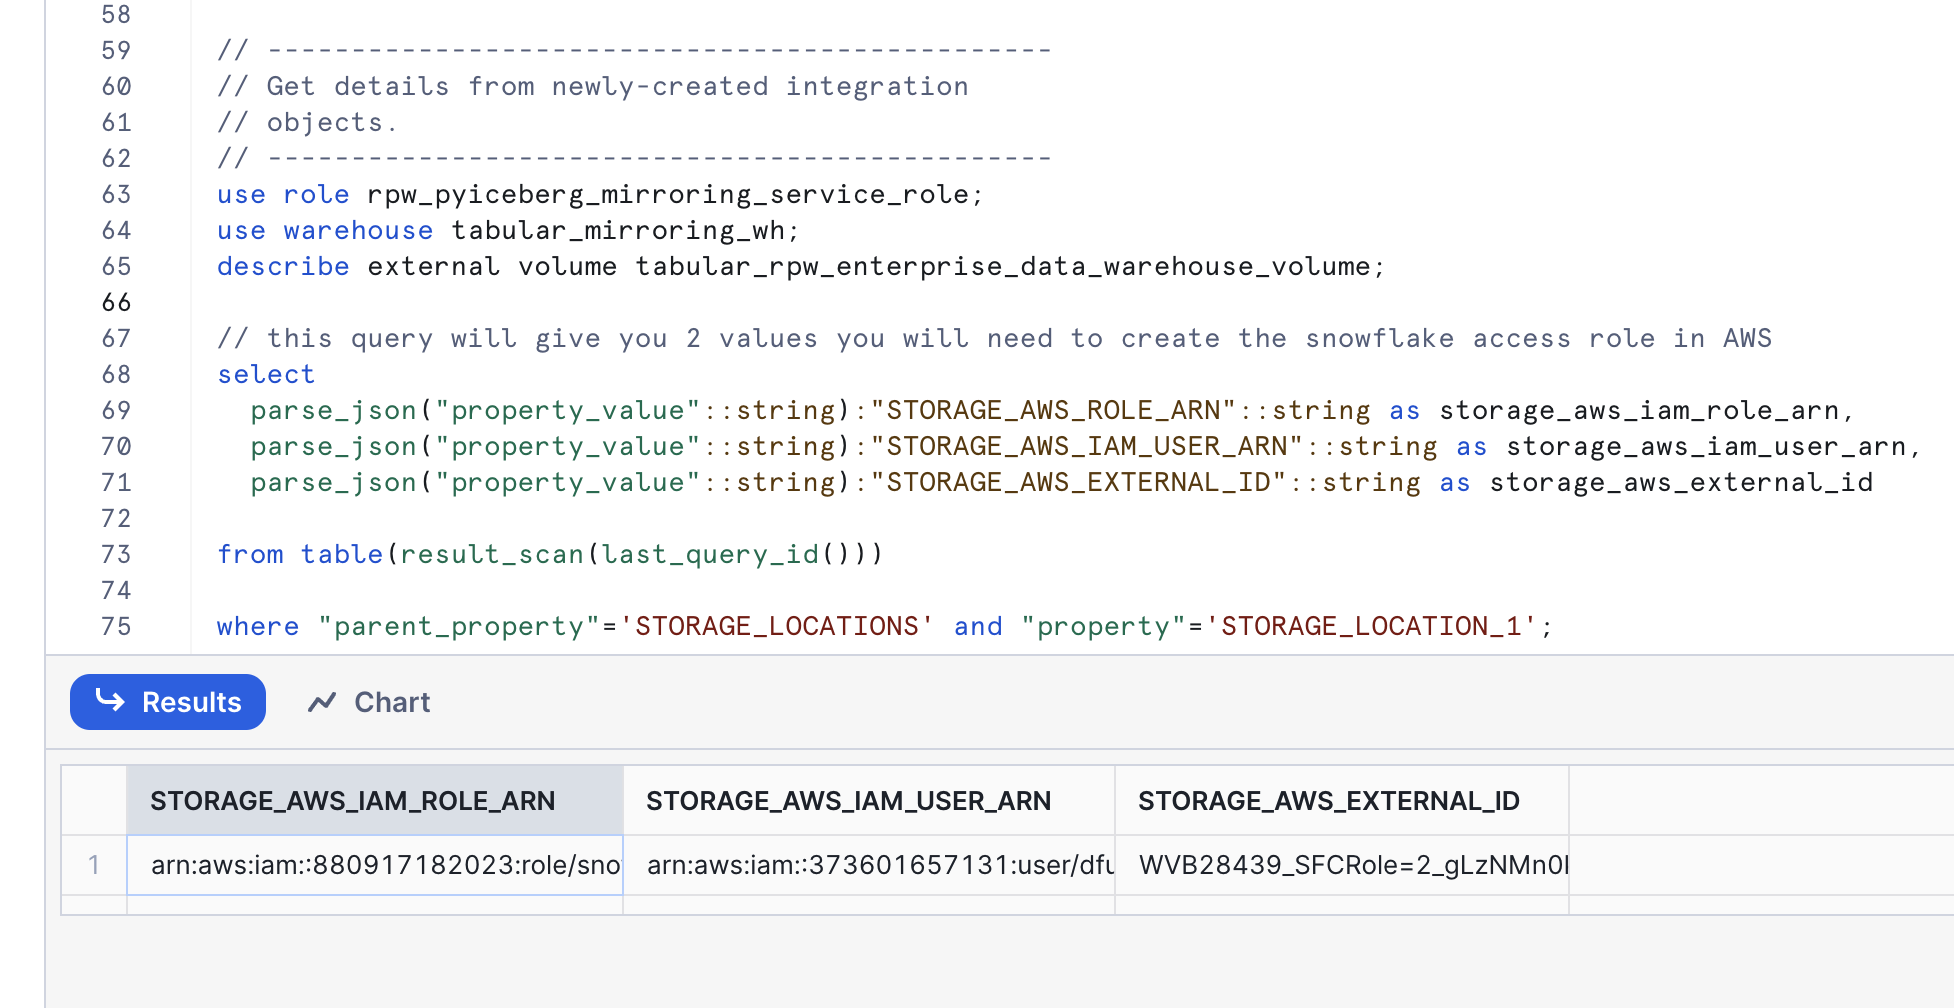

## 3. AWS Setup
No one panic, but it's time to log in to AWS and go to IAM and create a new policy + role 💪

### Create Policy
- let's start with the policy. We need to build a read only policy for your S3 location that holds the Tabular Iceberg warehouse you want to mirror
- check out the screenshot below for the one I have, then I'll share a JSON policy you can use with your own s3 locations

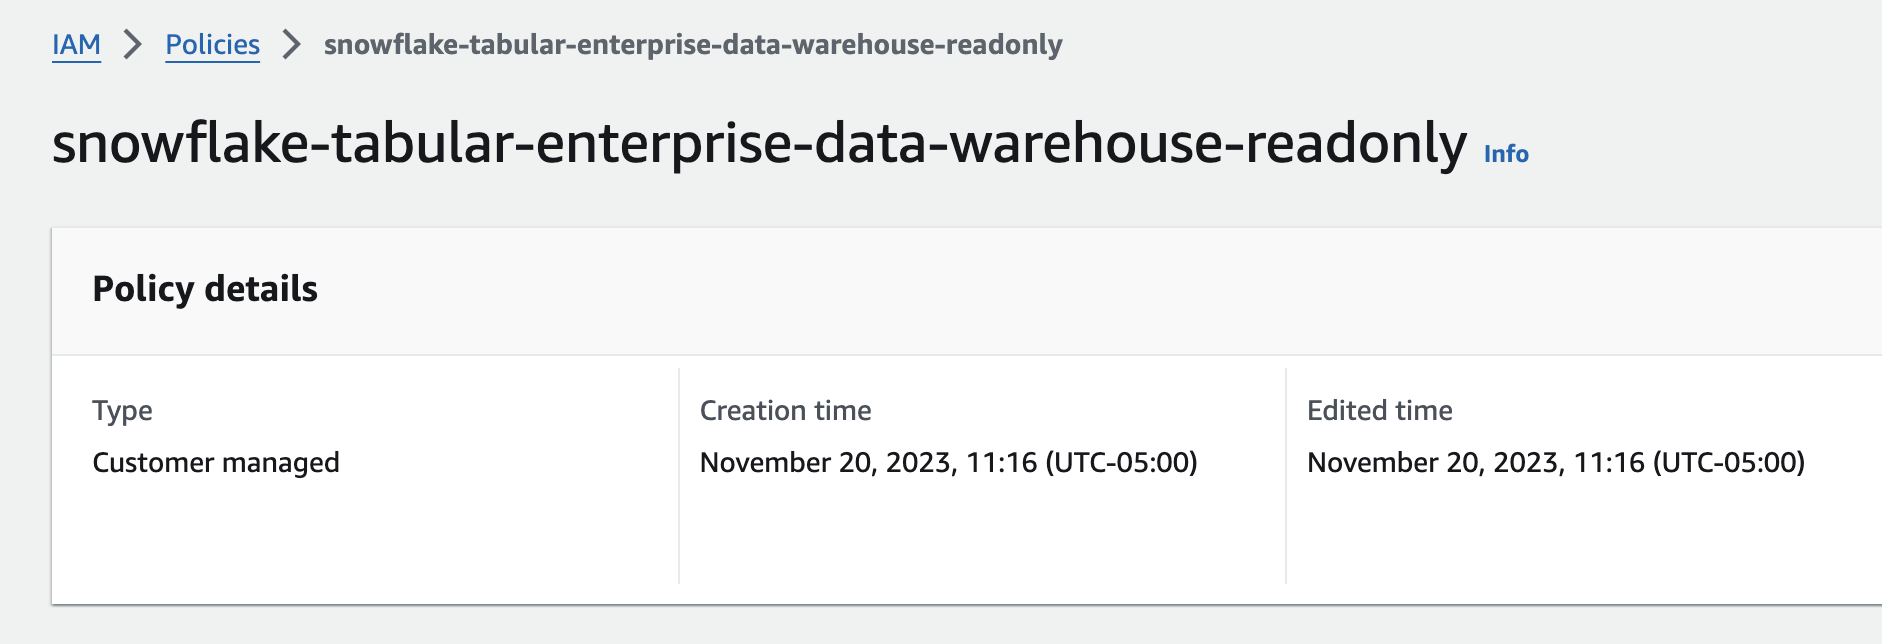

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "s3:GetObject",
                "s3:GetObjectVersion"
            ],
            "Resource": [
                "arn:aws:s3:::your_s3_bucket🦆/your_tabular_warehouse_UUID😎/*"
            ],
            "Effect": "Allow"
        },
        {
            "Condition": {
                "StringLike": {
                    "s3:prefix": [
                        "your_tabular_warehouse_UUID😎/*"
                    ]
                }
            },
            "Action": [
                "s3:ListBucket",
                "s3:GetBucketLocation"
            ],
            "Resource": [
                "arn:aws:s3:::your_s3_bucket🦆"
            ],
            "Effect": "Allow"
        }
    ]
}
```

### Create Role, *with Trust Policy*
- AWS > IAM > Create Role
- Important! You MUST name this role identically to what you told Snowflake to look for. So make sure those values are the same. This will be the `STORAGE_AWS_IAM_ROLE_ARN` value you received in your final Snowflake SQL query in the previous Snowflake Setup step 💪
- we need to attach the IAM Policy that you created above to this role
- now for the tricky part -- let's add a trust relationship so snowflake can use this role
  - remember the Snowflake values from the snowflake step? We need those. You should have
      - Snowflake AWS User ARN
      - Snowflake AWS External ID
  - these are super important, make sure to copy them EXACTLY! I mean it!
- see a screenshot of the role below along with JSON for the trust policy

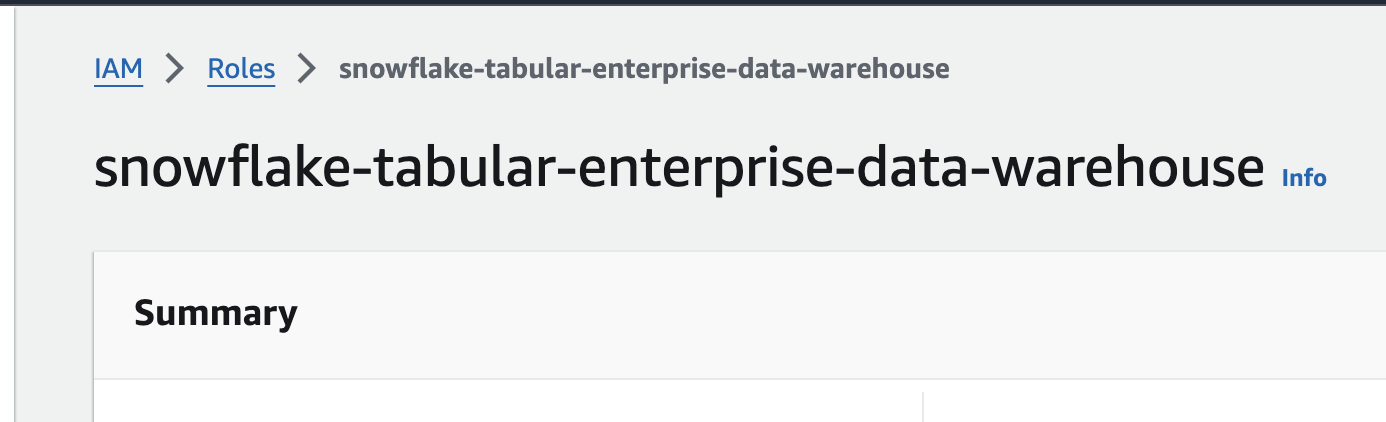

```json
{
    "Version": "2008-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "AWS": "snowflake user arn here ❄️"
            },
            "Action": "sts:AssumeRole",
            "Condition": {
                "StringEquals": {
                    "sts:ExternalId": "🏂 snowflake external ID here"
                }
            }
        }
    ]
}
```

💾 Suplex that save button and let's get down to business!


## 4. Pyiceberg Mirroring (aka, getting down to business 🕴️)
- remember everything we've been through. We're bonded after all this effort above
- keep the following values handy. I recommend putting a few of them in your `.env` file
  - you'll need your snowflake account id. You could stumble through the docs for this, OR just copy the results of running this in snowflake. Save this in `.env` as `SNOWFLAKE_ACCOUNT_IDENTIFIER`.
  ```sql
  select current_organization_name() || '-' || current_account_name() as snowflake_account_identifier;
  ```
  - you'll need your snowflake service user login name and password.
    - set these in your .env as `SNOWFLAKE_USERNAME` and `SNOWFLAKE_PASSWORD`
  - you tabular credential should already be tucked safe and sound in your .env file as `TABULAR_CREDENTIAL`

Now we're ready to cook 🍳

### ⚠️ Double check:
- Seriously, make sure you save that .env file. 
- if this is scary, you can ignore the `.env` file and just paste your credential in plaintext directly in this notebook -- but you should feel bad about your craftsmanship.


*One last note* -- you definitely don't have the same data I do. Make sure you use your own configs as required, but this should be a good starting point for you.

In [36]:
# load configs and establish our connection with Tabular 💪

from dotenv import load_dotenv
import os

from pyiceberg.catalog import load_catalog
from pyiceberg.exceptions import TableAlreadyExistsError

# You'll need a tabular credential. Member credential or service account will work fine
load_dotenv('./.env')

# Tabular config
TABULAR_CREDENTIAL       = os.environ['TABULAR_CREDENTIAL']
TABULAR_TARGET_WAREHOUSE = 'enterprise_data_warehouse' # replace this with your tabular warehouse name
TABULAR_CATALOG_URI      = 'https://api.tabular.io/ws' # unless you're a single tenant user, you don't need to change this
TABULAR_DATABASE         = 'batch_raw' # this should already exist and contain the tables you want to mirror

# Snowflake config
SNOWFLAKE_VOLUME = 'tabular_rpw_enterprise_data_warehouse_volume' # You created this in your Snowflake script. Please copy/paste that value here
SNOWFLAKE_CATALOG = 'tabular_rpw_enterprise_data_warehouse_catalog' # You created this in your Snowflake script. Please copy/paste that value here
SNOWFLAKE_USERNAME           = os.environ['SNOWFLAKE_USERNAME']
SNOWFLAKE_PASSWORD           = os.environ['SNOWFLAKE_PASSWORD']
SNOWFLAKE_ACCOUNT_IDENTIFIER = os.environ['SNOWFLAKE_ACCOUNT_IDENTIFIER']
SNOWFLAKE_DATABASE           = 'enterprise_data_warehouse' # this should already exist in snowflake
SNOWFLAKE_SCHEMA             = TABULAR_DATABASE # tabular DB's are semantically similar to snowflake schemas. this does not have to exist already

catalog_properties = {
    'uri':        TABULAR_CATALOG_URI,
    'credential': TABULAR_CREDENTIAL,
    'warehouse':  TABULAR_TARGET_WAREHOUSE
}
catalog = load_catalog(**catalog_properties)

In [23]:
# get tables to build mirrors for 💪
tables_to_mirror = []
for _, tablename in catalog.list_tables(TABULAR_DATABASE):
  tables_to_mirror.append(catalog.load_table(f"{TABULAR_DATABASE}.{tablename}"))
  print(f"Found tabular table: '{TABULAR_DATABASE}.{tables_to_mirror[-1].identifier[-1]}'")

Found tabular table: 'batch_raw.directors'
Found tabular table: 'batch_raw.films'
Found tabular table: 'batch_raw.films_cdc_pipeline'
Found tabular table: 'batch_raw.films_cdc_pipeline_changelog'
Found tabular table: 'batch_raw.films_changelog'
Found tabular table: 'batch_raw.films_demo'
Found tabular table: 'batch_raw.films_demo_changelog'
Found tabular table: 'batch_raw.films_demo_today'
Found tabular table: 'batch_raw.ls_test_not_gz'
Found tabular table: 'batch_raw.serverless_weather_raw'


In [37]:
import snowflake.connector

# Snowflake connection parameters
# These variables are gathered in the initial python cell above ⬆️
snowflake_config = {
    "user": SNOWFLAKE_USERNAME,
    "password": SNOWFLAKE_PASSWORD,
    "account": SNOWFLAKE_ACCOUNT_IDENTIFIER
}

# Create a connection object
snowflake_conn = snowflake.connector.connect(**snowflake_config)

In [38]:
# Validate the connection details before mirroring
try:
  curs = snowflake_conn.cursor()

  # set session configs
  curs.execute(f'use database {SNOWFLAKE_DATABASE}')

  # validation query
  curs.execute('select current_user(), current_role(), current_database(), current_warehouse(), 1=1 as warehouse_is_usable')
  row = curs.fetchone()
  print(f"""
    Snowflake connection validity check:
      - Current User:         '{row[0]}'
      - Current Role:         '{row[1]}'
      - Current Database:     '{row[2]}'
      - Current Warehouse:    '{row[3]}'
      - Warehouse is usable?: '{row[4]}'""")
  
  # check if the schema exists
  curs.execute(f"show schemas like '{SNOWFLAKE_SCHEMA}' in database {SNOWFLAKE_DATABASE}")
  row = curs.fetchone()
  
  if row is None:
    print(f"Schema '{SNOWFLAKE_DATABASE}.{SNOWFLAKE_SCHEMA}' not found. Attempting to create it...")
    curs.execute(f"create schema {SNOWFLAKE_DATABASE}.{SNOWFLAKE_SCHEMA}")
    print(f"\tSchema '{SNOWFLAKE_DATABASE}.{SNOWFLAKE_SCHEMA}' successfully created 💃")
    
  # use and print current schema
  curs.execute(f"use schema {SNOWFLAKE_DATABASE}.{SNOWFLAKE_SCHEMA}")
  print(f"      - Current schema:       '{SNOWFLAKE_DATABASE}.{SNOWFLAKE_SCHEMA}'")
  
except Exception as e:
  print(f'Snowflake connection error:\n{e}')


    Snowflake connection validity check:
      - Current User:         'RPW_PYICEBERG_MIRRORING_SERVICE_USER'
      - Current Role:         'RPW_PYICEBERG_MIRRORING_SERVICE_ROLE'
      - Current Database:     'ENTERPRISE_DATA_WAREHOUSE'
      - Current Warehouse:    'TABULAR_MIRRORING_WH'
      - Warehouse is usable?: 'True'
      - Current schema:       'enterprise_data_warehouse.batch_raw'


In [54]:
# Build snowflake mirrors 💪
# test query to validate the basics
curs = snowflake_conn.cursor()
for table_to_mirror in tables_to_mirror:
  try:    
    # grab the table name to use.
    # Note: If you expect naming collisions, you can prefix these by their tabular database name or whatever you like
    snowflake_mirror_tablename = table_to_mirror.identifier[-1] # last part of the identifier is the table name
    metadata_file_path = '/'.join(table_to_mirror.metadata_location.split('/')[-3:])
    mirror_query = f"""
      create or replace iceberg table {SNOWFLAKE_DATABASE}.{SNOWFLAKE_SCHEMA}.{snowflake_mirror_tablename}
        external_volume = '{SNOWFLAKE_VOLUME}'
        catalog = '{SNOWFLAKE_CATALOG}'
        metadata_file_path = '{metadata_file_path}'
        copy grants;"""
    print(f"Attempting mirror command:{mirror_query}")
    curs.execute(mirror_query)
    print(f"✅ Success!\n\n")
    
  except Exception as e:
    
    print(f'❌ Failure. Snowflake mirroring error for table "{table_to_mirror.identifier[1]}.{table_to_mirror.identifier[2]}":\n{e}')
    

Attempting mirror command:
      create or replace iceberg table enterprise_data_warehouse.batch_raw.directors
        external_volume = 'tabular_rpw_enterprise_data_warehouse_volume'
        catalog = 'tabular_rpw_enterprise_data_warehouse_catalog'
        metadata_file_path = '18568c7f-1d19-454f-a96f-54f403457466/metadata/00067-fa4290e1-6e93-4242-8a84-74fedd7a8bc2.gz.metadata.json'
        copy grants;
    
✅ Success!
Attempting mirror command:
      create or replace iceberg table enterprise_data_warehouse.batch_raw.films
        external_volume = 'tabular_rpw_enterprise_data_warehouse_volume'
        catalog = 'tabular_rpw_enterprise_data_warehouse_catalog'
        metadata_file_path = '0b1728d2-b825-4800-95f9-42c67a4f5e1f/metadata/00000-9ff2ad3b-8057-4e8c-8a61-3a9563aa7717.gz.metadata.json'
        copy grants;
    
✅ Success!
Attempting mirror command:
      create or replace iceberg table enterprise_data_warehouse.batch_raw.films_cdc_pipeline
        external_volume = 'tabular_r